# 3 - Packed Padded Sequences, Masking and Inference

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

First, we'll import all the modules as before, with the addition of the `matplotlib` modules used for viewing the attention.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

Next, we'll set the random seed for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

As before, we'll import spaCy and define the German and English tokenizers.

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

When using packed padded sequences, we need to tell PyTorch how long the actual (non-padded) sequences are. Luckily for us, TorchText's `Field` objects allow us to use the `include_lengths` argument, this will cause our `batch.src` to be a tuple. The first element of the tuple is the same as before, a batch of numericalized source sentence as a tensor, and the second element is the non-padded lengths of each source sentence within the batch.

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

We then load the data.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

And build the vocabulary.

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Next, we handle the iterators.

One quirk about packed padded sequences is that all elements in the batch need to be sorted by their non-padded lengths in descending order, i.e. the first sentence in the batch needs to be the longest. We use two arguments of the iterator to handle this, `sort_within_batch` which tells the iterator that the contents of the batch need to be sorted, and `sort_key` a function which tells the iterator how to sort the elements in the batch. Here, we sort by the length of the `src` sentence.

In [8]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        
        packed_outputs, hidden = self.rnn(packed_embedded)
                     
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [10]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token, sos token and the eos token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

To use this model for inference, we simply pass a target sentence, `trg`, of `None`. This will set `inference` to true and create a fake `trg` tensor filled with `<sos>` tokens. We need to fill it with `<sos>` tokens as one needs to be passed to the decoder to start the decoding, the rest are never used as we assert the teacher forcing ratio is 0 and thus the model only ever uses its own predictions. We set the dummy target tensor to have a max length of 100, meaning that is the maximum number of target tokens we will attempt to output.

We also create an `attentions` tensor to store the values of attention for inference.

Within the decoder loop, while doing inference, we check if the decoded token is the `<eos>` token, and if so we immediately stop decoding and return the translation and attentions generated so far.

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

Next up, initializing the model and placing it on the GPU.

In [13]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
PAD_IDX = SRC.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

Then, we initialize the model parameters.

In [14]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,917 trainable parameters


Then we define our optimizer and criterion. We have already initialized `PAD_IDX` when initializing the model, so we don't need to do it again.

In [16]:
optimizer = optim.Adam(model.parameters())

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Next, we'll define our training and evaluation loops.

As we are using `include_lengths = True` for our source field, `batch.src` is now a tuple with the first element being the numericalized tensor representing the sentence and the second element being the lengths of each sentence within the batch.

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, attention = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Then, we'll define a useful function for timing how long epochs take.

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The penultimate step is to train our model.

In [21]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 36s
	Train Loss: 5.067 | Train PPL: 158.684
	 Val. Loss: 4.781 |  Val. PPL: 119.276
Epoch: 02 | Time: 0m 34s
	Train Loss: 4.131 | Train PPL:  62.209
	 Val. Loss: 4.198 |  Val. PPL:  66.580
Epoch: 03 | Time: 0m 34s
	Train Loss: 3.380 | Train PPL:  29.357
	 Val. Loss: 3.587 |  Val. PPL:  36.139
Epoch: 04 | Time: 0m 34s
	Train Loss: 2.868 | Train PPL:  17.605
	 Val. Loss: 3.432 |  Val. PPL:  30.946
Epoch: 05 | Time: 0m 34s
	Train Loss: 2.483 | Train PPL:  11.978
	 Val. Loss: 3.286 |  Val. PPL:  26.743
Epoch: 06 | Time: 0m 34s
	Train Loss: 2.194 | Train PPL:   8.971
	 Val. Loss: 3.310 |  Val. PPL:  27.387
Epoch: 07 | Time: 0m 33s
	Train Loss: 1.957 | Train PPL:   7.078
	 Val. Loss: 3.160 |  Val. PPL:  23.559
Epoch: 08 | Time: 0m 33s
	Train Loss: 1.757 | Train PPL:   5.793
	 Val. Loss: 3.228 |  Val. PPL:  25.228
Epoch: 09 | Time: 0m 33s
	Train Loss: 1.599 | Train PPL:   4.950
	 Val. Loss: 3.295 |  Val. PPL:  26.985
Epoch: 10 | Time: 0m 33s
	Train Loss: 1.491 | Train PPL

Finally, we load the parameters from our best validation loss and get our results on the test set.

In [22]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.160 | Test PPL:  23.577 |


## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples you see in paper as they use hidden dimension sizes of 1000 and train for 4 days!

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize our input/src sentence 
- lowercase our tokens and append the start and end of sequence tokens
- use our vocabulary to numericalize our tokens by converting them into their indexes
- get the sentence length and convert into a tensor
- convert the numericalized sentence into a tensor, add a batch dimension and place on GPU
- pass inputs into the model, making sure `trg` is set to `None` for inference and the teacher forcing ratio is zero
  - this gives us the raw (unnormalized) predictions for each token in our target sequence
- get the highest predicted token index for each element in the target sequence using `argmax`
- convert these indexes into strings
- as the first element in our output and attention tensors from our models are all zeros, we trim these before returning them

In [23]:
def translate_sentence(model, sentence):
    model.eval()
    tokenized = tokenize_de(sentence) 
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>']
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TRG.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [24]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_de(candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [25]:
example_idx = 4

src = ' '.join(vars(train_data.examples[example_idx])['src'])
trg = ' '.join(vars(train_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = zwei männer stehen am herd und bereiten essen zu .
trg = two men are at the stove preparing food .


Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model translated 100% correctly. Notice how when translating *zwei* corretly into *two* it didn't seem to pay attention to *zwei* at all. However when translating *männer stehen* into *men are standing* it managed to get the attention pretty much spot on! 

predicted trg = ['two', 'men', 'are', 'standing', 'at', 'the', 'stove', 'preparing', 'food', '.']


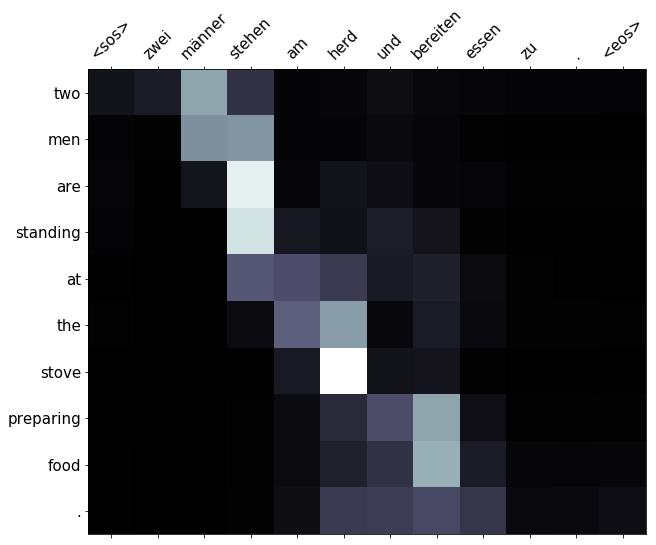

In [26]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

Translations from the training set could simply be memorized by the model. So it's only fair we look at translations from the validation and testing set too.

Starting with the validation set, let's get an example.

In [27]:
example_idx = 35

src = ' '.join(vars(valid_data.examples[example_idx])['src'])
trg = ' '.join(vars(valid_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = eine frau sitzt an einer dunklen bar .
trg = a woman sits at a dark bar .


Then let's generate our translation and view the attention.

Here, the translation is slightly different, it replaced *sits* with *sitting*, but the meaning is pretty much the same. Notice how it correctly pays attention to *eine frau sitzt* when translating *a woman sitting* and *dunklen bar* when translating *dark bar*. 

predicted trg = ['a', 'woman', 'sitting', 'at', 'a', 'dark', 'bar', '.']


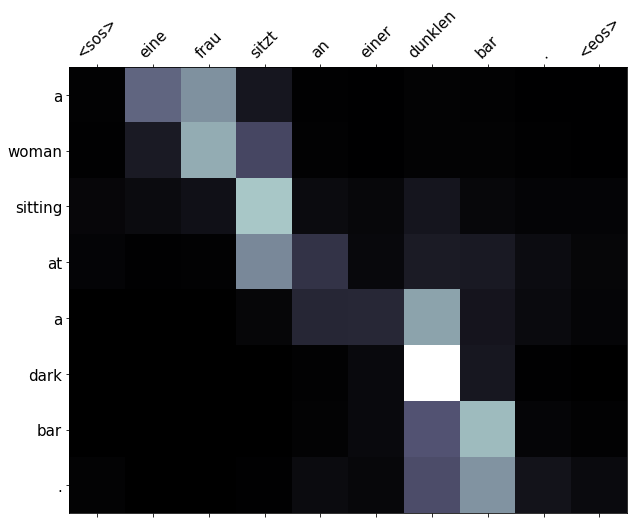

In [28]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

Finally, let's get an example from the test set.

In [29]:
example_idx = 4

src = ' '.join(vars(test_data.examples[example_idx])['src'])
trg = ' '.join(vars(test_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = leute reparieren das dach eines hauses .
trg = people are fixing the roof of a house .


Here we can see the model produces a translation that is slightly different but carries the same meaning. We can also see how it correctly pays attention to sensibile source words, such as *leute reparieren* when translating to *people fixing*!

predicted trg = ['people', 'fixing', 'the', 'roof', 'of', 'a', 'house', '.']


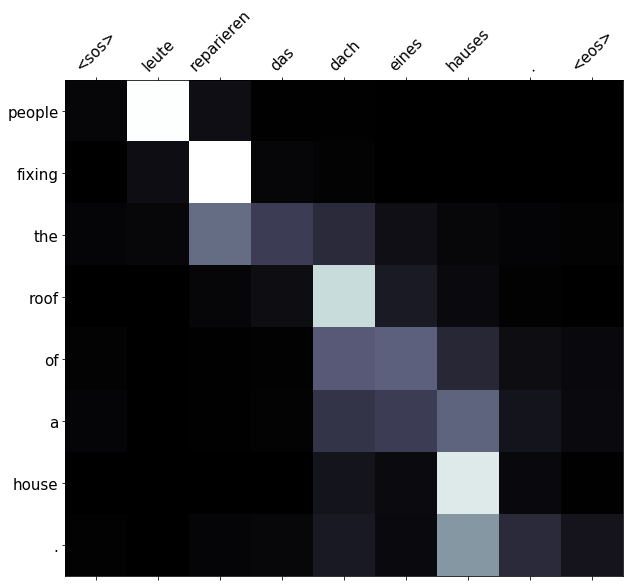

In [30]:
translation, attention = translate_sentence(model, src)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)